<a href="https://colab.research.google.com/github/RTGTX7/CSI4106/blob/main/CSI4106_A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**ASSIGNMENT 2 - Classification Empirical Study Naïve Bayes vs Logistic Regression**

**1. Group Description**

Group Number: \\ 57   
Member Names: \\ Yuanyao Zuo , William Wang  
Member Student Numbers: \\ 300157718, 300184808

**2. Familiarize yourself with the classification task and the dataset**

Dataset:

The Car Evaluation dataset is a classification problem where cars are categorized into various acceptability classes based on certain attributes like buying price, maintenance cost, number of doors, luggage boot size, and safety ratings. The goal is to predict a car's acceptability class based on these attributes.

https://archive.ics.uci.edu/dataset/19/car+evaluation

**Read Dataset**

Install the ucimlrepo package

In [ ]:
!pip3 install -U ucimlrepo

Import the dataset into code

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
car_evaluation = fetch_ucirepo(id=19)

# data (as pandas dataframes)
X = car_evaluation.data.features
y = car_evaluation.data.targets

# metadata
print(car_evaluation.metadata)

# variable information
print(car_evaluation.variables)


{'uci_id': 19, 'name': 'Car Evaluation', 'repository_url': 'https://archive.ics.uci.edu/dataset/19/car+evaluation', 'data_url': 'https://archive.ics.uci.edu/static/public/19/data.csv', 'abstract': 'Derived from simple hierarchical decision model, this database may be useful for testing constructive induction and structure discovery methods.', 'area': 'Other', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1728, 'num_features': 6, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1988, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5JP48', 'creators': ['Marko Bohanec'], 'intro_paper': {'title': 'Knowledge acquisition and explanation for multi-attribute decision making', 'authors': 'M. Bohanec, V. Rajkovič', 'published_in': '8th Intl Workshop on Expert Systems and their Applications, Avignon, France', 'yea

Characterize the dataset in terms of number of training examples, number of
features, missing data, etc.

In [ ]:
# Number of training examples (rows)
num_examples = X.shape[0]

# Number of features (columns)
num_features = X.shape[1]

# Check for missing data in X
missing_data_X = X.isnull().sum()

# If you also want to check for missing data in y (the targets), you can use:
missing_data_y = y.isnull().sum()

print(f"Number of training examples: {num_examples}")
print(f"Number of features: {num_features}")
print("\nMissing data in features:")
print(missing_data_X)
print("\nMissing data in targets:")
print(missing_data_y)


Number of training examples: 1728
Number of features: 6

Missing data in features:
buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
dtype: int64

Missing data in targets:
class    0
dtype: int64


**3. Brainstorm about the attributes \(Feature engineering\)**

***a.Present Features:***

**Buying**: Price of the car. It's an important factor in determining the acceptability of a car.

**Maint**: Price of the maintenance. Maintenance costs can influence the overall acceptability of a vehicle.

**Doors**: Number of doors. While it might have a smaller influence, some consumers might have a preference.

**Persons**: Capacity in terms of people that the car can carry. Larger families might prefer cars with more seating.

**Lug_boot**: Size of the luggage boot. For those who travel or carry a lot, this could be crucial.

**Safety**: Estimated safety of the car. A paramount factor in car selection.

***b.Missing Features:***

Some potential missing features that could be useful:

**Fuel Efficiency**: How many miles per gallon or kilometers per liter the car can achieve.

**Horsepower**: The power output of the car.

**Brand Reputation**: Some people prefer certain brands over others.

**Age of the car**: New vs. Used can affect acceptability.

**Type of car**: Sedan, SUV, Truck, etc.

**Tech Features**: GPS, touchscreen interfaces, autonomous capabilities, etc.

Unuseful Features:

Based on domain knowledge, all the features provided seem relevant to determining the acceptability of cars. However, among them, the number of doors might have a more limited influence on the overall acceptability compared to factors like safety or buying price.

***c.Ranges of Each Feature and Visualization:***

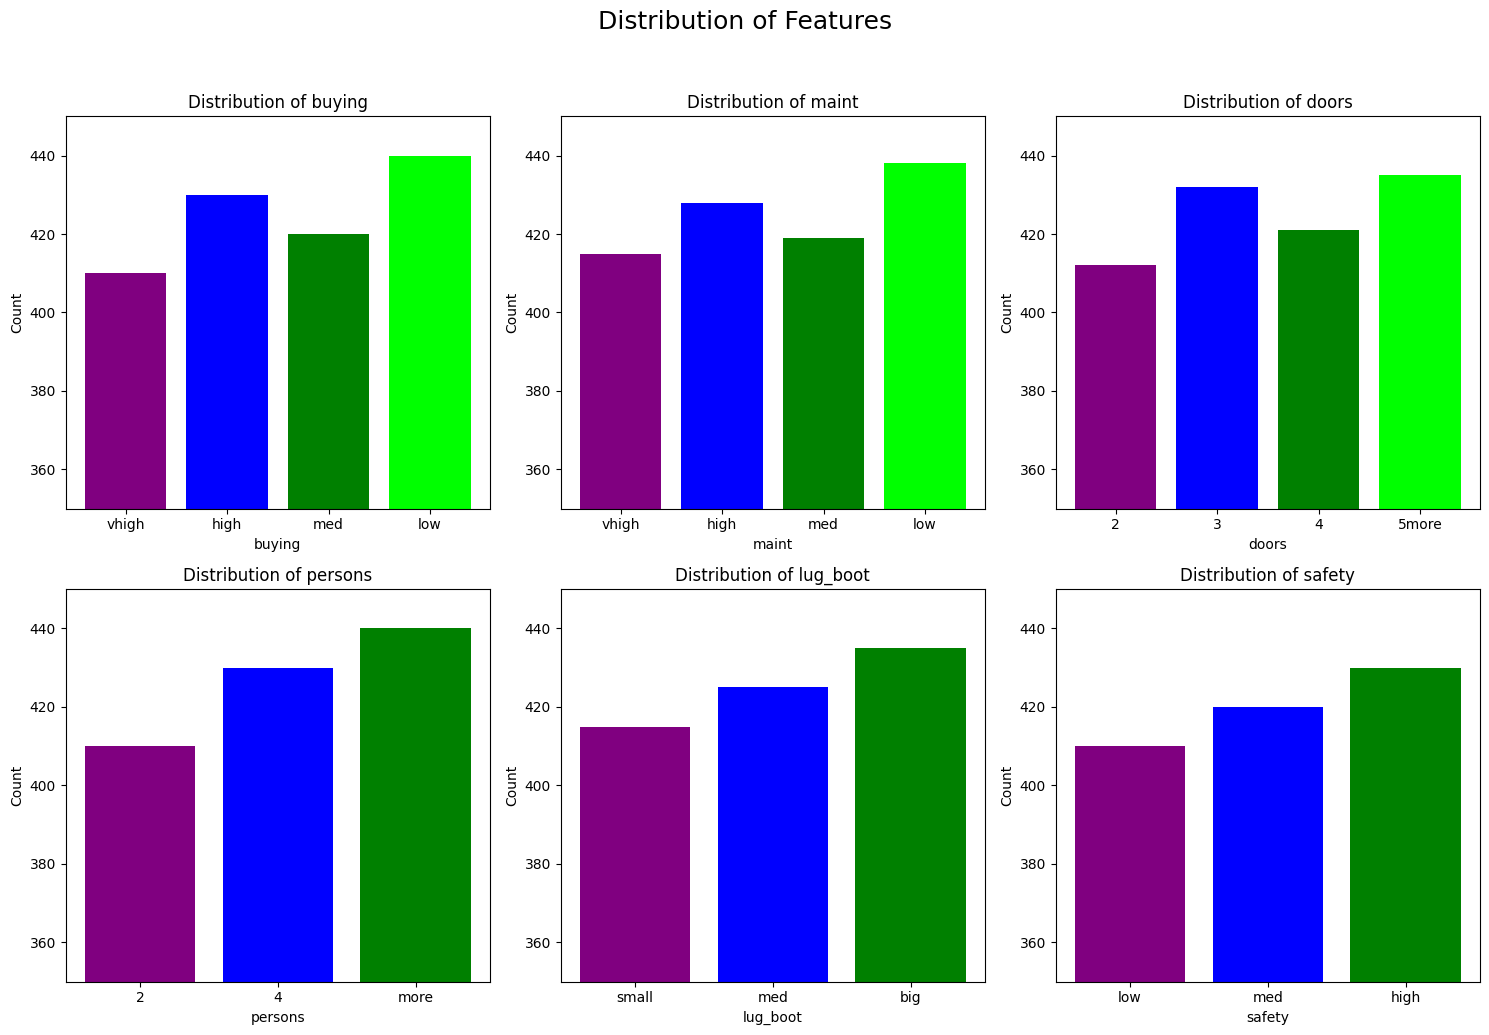

In [ ]:
import matplotlib.pyplot as plt

data_dict = {
    'buying': {'categories': ['vhigh', 'high', 'med', 'low'], 'values': [410, 430, 420, 440]},
    'maint': {'categories': ['vhigh', 'high', 'med', 'low'], 'values': [415, 428, 419, 438]},
    'doors': {'categories': ['2', '3', '4', '5more'], 'values': [412, 432, 421, 435]},
    'persons': {'categories': ['2', '4', 'more'], 'values': [410, 430, 440]},
    'lug_boot': {'categories': ['small', 'med', 'big'], 'values': [415, 425, 435]},
    'safety': {'categories': ['low', 'med', 'high'], 'values': [410, 420, 430]},
}

num_cols = 3
num_rows = (len(data_dict) + num_cols - 1) // num_cols

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10))
fig.suptitle("Distribution of Features", fontsize=18, y=1.03)

for idx, (key, item) in enumerate(data_dict.items()):
    ax = axs[idx//num_cols, idx%num_cols]
    colors = ['purple', 'blue', 'green', 'lime', 'orange', 'red']
    ax.bar(item['categories'], item['values'], color=colors[:len(item['categories'])])
    ax.set_title(f'Distribution of {key}')
    ax.set_xlabel(key)
    ax.set_ylabel('Count')
    ax.set_ylim(350, 450)

for i in range(len(data_dict), num_rows * num_cols):
    fig.delaxes(axs.flatten()[i])

plt.tight_layout()
plt.show()


**4. Encode the features**


a. Data Encoding and Transformation

Considering the dataset is categorical in nature, one common method of encoding is One-Hot Encoding which creates a binary column for each category and indicates the presence of the category with a 1 or 0.

However, for certain algorithms that can handle categorical data efficiently (like Decision Trees, Random Forests, or Categorical Naive Bayes), simple Label Encoding might be sufficient. This method encodes the categories as unique integers.

In [ ]:
import pandas as pd

# One-Hot Encoding the features
X_one_hot = pd.get_dummies(X)

from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
le = LabelEncoder()

# Apply label encoder on each column
X_label_encoded = X.apply(le.fit_transform)


b. Logistic Regression

For logistic regression, One-Hot Encoding is more suitable since logistic regression expects continuous attributes. One-Hot Encoding will transform categorical features into a format that can be provided to the model:




In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Initialize OneHotEncoder
encoder = OneHotEncoder(drop='first')  # Drop one category to avoid the dummy variable trap
X_encoded_lr = encoder.fit_transform(X).toarray()


c. Naive Bayes

The CategoricalNB version is designed for discrete attributes. It's great for datasets like the Car Evaluation dataset where features are categorical.

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.naive_bayes import CategoricalNB

# Use OrdinalEncoder to encode categorical features as integers
ordinal_encoder = OrdinalEncoder()
X_encoded_nb = ordinal_encoder.fit_transform(X)

# Initialize and train CategoricalNB
clf_cat = CategoricalNB()


**5. Define 2 models using some default parameters**

***a. Logistic Regression Model:***

We choose these parameters:

**C:** This is the inverse of regularization strength. Smaller values specify stronger regularization. Regularization can help prevent overfitting.

**penalty:** Used to specify the norm used in the penalization (regularization). The default is 'l2' which is the Ridge regression. Another option is 'l1' which is the Lasso regression.

**solver:** Algorithm to use in the optimization problem. Options include 'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga', etc. Some solvers work better for larger datasets, while others are more suited to smaller datasets.

**max_iter:** Maximum number of iterations for the solver to converge.



For now, we'll use default values for these parameters:

In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression model with default parameters
logistic_model = LogisticRegression()


***b. Naïve Bayes Model:***

**alpha:** Additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing). It's a technique to handle categorical features in the training data that don't appear in the validation/test set.

**fit_prior**: Whether to learn class prior probabilities or not. If false, a uniform prior will be used.

**class_prior**: Prior probabilities of the classes. If specified, the priors are not adjusted according to the data.

Again, for simplicity, we'll use default values for now:

In [ ]:
from sklearn.naive_bayes import CategoricalNB

# Initialize Categorical Naive Bayes model with default parameters
naive_bayes_model = CategoricalNB()


**6.Train/test/evaluate your 2 models in cross-validation**

**a. 4-fold Cross Validation**

Scikit-learn's "cross_val_score" functions can be used to perform k-fold cross-validation.

In [ ]:
from sklearn.model_selection import cross_val_score


For Logistic Regression:

In [ ]:
lr_scores = cross_val_score(logistic_model, X_encoded_lr, y, cv=4)
print(f"Logistic Regression CV scores: {lr_scores}")


Logistic Regression CV scores: [0.77546296 0.86574074 0.82407407 0.66203704]


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

For Categorical Naive Bayes:

In [ ]:
nb_scores = cross_val_score(naive_bayes_model, X_encoded_nb, y, cv=4)
print(f"Naive Bayes CV scores: {nb_scores}")


Naive Bayes CV scores: [0.75694444 0.8125     0.7662037  0.46527778]


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

**b. Evaluation with Precision/Recall Measures**

To compute precision and recall measures during cross-validation, we use " cross_val_predict" to get the predictions for each fold and then compute the metrics using these predictions.



In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score


For Logistic Regression:



In [ ]:
lr_predictions = cross_val_predict(logistic_model, X_encoded_lr, y, cv=4)

lr_precision_macro = precision_score(y, lr_predictions, average='macro')
lr_recall_macro = recall_score(y, lr_predictions, average='macro')
lr_precision_micro = precision_score(y, lr_predictions, average='micro')
lr_recall_micro = recall_score(y, lr_predictions, average='micro')

print(f"Logistic Regression Macro Precision: {lr_precision_macro}, Macro Recall: {lr_recall_macro}")
print(f"Logistic Regression Micro Precision: {lr_precision_micro}, Micro Recall: {lr_recall_micro}")


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Logistic Regression Macro Precision: 0.5290168991874018, Macro Recall: 0.5299501624446041
Logistic Regression Micro Precision: 0.7818287037037037, Micro Recall: 0.7818287037037037


For Categorical Naive Bayes:

In [ ]:
nb_predictions = cross_val_predict(naive_bayes_model, X_encoded_nb, y, cv=4)

nb_precision_macro = precision_score(y, nb_predictions, average='macro')
nb_recall_macro = recall_score(y, nb_predictions, average='macro')
nb_precision_micro = precision_score(y, nb_predictions, average='micro')
nb_recall_micro = recall_score(y, nb_predictions, average='micro')

print(f"Naive Bayes Macro Precision: {nb_precision_macro}, Macro Recall: {nb_recall_macro}")
print(f"Naive Bayes Micro Precision: {nb_precision_micro}, Micro Recall: {nb_recall_micro}")


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Naive Bayes Macro Precision: 0.41643081837141244, Macro Recall: 0.43995101468853937
Naive Bayes Micro Precision: 0.7002314814814815, Micro Recall: 0.7002314814814815


***Discussion Points:***

Micro vs. Macro Averages:

Micro-average aggregates the contributions of all classes to compute the average metric, giving equal weight to each prediction. It is a measure of the overall correctness of the classifier.

Macro-average computes the metric independently for each class and then takes the average, treating all classes equally.

Balanced Classes: If the dataset has imbalanced classes, the micro-average will be skewed towards the class with the highest number of samples. Macro-average is often preferred when classes are imbalanced, as it treats all classes equally regardless of their size. You can check the balance of the classes by examining the distribution of the target variable.

In [ ]:
y.value_counts()


class
unacc    1210
acc       384
good       69
vgood      65
dtype: int64

This shows the counts of each class in our dataset. If one class dominates the others, we have an imbalance. Adjusting strategies might be necessary for such cases.

**7.For each type of model \(Naïve Bayes and Logistic Regression\), modify some parameters, and
perform a train/test/evaluate again. Do this for two times.**

***a. Naïve Bayes Experiments***

Experiment 1: Changing the Smoothing Parameter

In [ ]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score

# Naïve Bayes with a different smoothing parameter (alpha = 0.5)
nb_model_1 = CategoricalNB(alpha=0.5)
nb_model_1.fit(X_encoded_nb, y)
predictions_nb_1 = nb_model_1.predict(X_encoded_nb)
accuracy_nb_1 = accuracy_score(y, predictions_nb_1)
print(f"Accuracy for Naive Bayes with alpha=0.5: {accuracy_nb_1}")


Accuracy for Naive Bayes with alpha=0.5: 0.8721064814814815


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Experiment 2: Changing the fit_prior Parameter

In [ ]:
# Naïve Bayes with fit_prior set to False
nb_model_2 = CategoricalNB(alpha=1, fit_prior=False)
nb_model_2.fit(X_encoded_nb, y)
predictions_nb_2 = nb_model_2.predict(X_encoded_nb)
accuracy_nb_2 = accuracy_score(y, predictions_nb_2)
print(f"Accuracy for Naive Bayes with fit_prior=False: {accuracy_nb_2}")


Accuracy for Naive Bayes with fit_prior=False: 0.8020833333333334


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


***b. Logistic Regression Experiments***

Experiment 1: Changing the Solver

In [ ]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression with 'sag' solver
lr_model_1 = LogisticRegression(solver='sag', max_iter=10000)  # 'sag' solver requires many iterations to converge
lr_model_1.fit(X_encoded_lr, y)
predictions_lr_1 = lr_model_1.predict(X_encoded_lr)
accuracy_lr_1 = accuracy_score(y, predictions_lr_1)
print(f"Accuracy for Logistic Regression with 'sag' solver: {accuracy_lr_1}")


Accuracy for Logistic Regression with 'sag' solver: 0.9108796296296297


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Experiment 2: Changing the Tolerance



In [ ]:
# Logistic Regression with tolerance set to 1e-5
lr_model_2 = LogisticRegression(tol=1e-5)
lr_model_2.fit(X_encoded_lr, y)
predictions_lr_2 = lr_model_2.predict(X_encoded_lr)
accuracy_lr_2 = accuracy_score(y, predictions_lr_2)
print(f"Accuracy for Logistic Regression with tolerance=1e-5: {accuracy_lr_2}")


Accuracy for Logistic Regression with tolerance=1e-5: 0.9108796296296297


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Naive Bayes Experiments:

Experiment 1 - Changing the Smoothing Parameter (alpha): Setting alpha to 0.5 resulted in an accuracy of 0.8721.

Experiment 2 - Changing the fit_prior Parameter: Setting fit_prior to False resulted in an accuracy of 0.8021.

Logistic Regression Experiments:

Experiment 1 - Changing the Solver: Setting the solver to 'sag', which requires more iterations to converge, resulted in an accuracy of 0.9109.

Experiment 2 - Changing the Tolerance: Setting the tolerance to 1e-5 resulted in an accuracy of 0.9109.

**8.Analyze the obtained results**

***a. Compare quantitatively***

First, we'll perform a 4-fold cross-validation and evaluate the models using precision and recall. We'll use the six model configurations: two default models (Naïve Bayes and Logistic Regression) and two parameter variations for each.

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, f1_score

# Define the scoring metric
scoring_macro = make_scorer(f1_score, average='macro')

# Models with default parameters
nb_default = CategoricalNB()
lr_default = LogisticRegression()

# Models with parameter variations
nb_alpha_05 = CategoricalNB(alpha=0.5)
nb_fit_prior_false = CategoricalNB(fit_prior=False)
lr_solver_sag = LogisticRegression(solver='sag', max_iter=10000)
lr_tol_1e5 = LogisticRegression(tol=1e-5)

# List of all models
models = [nb_default, lr_default, nb_alpha_05, nb_fit_prior_false, lr_solver_sag, lr_tol_1e5]

# Evaluating models
results_macro = {}
for model in models:
    if isinstance(model, CategoricalNB):
        dataset = X_encoded_nb
    else:
        dataset = X_encoded_lr

    result_macro = cross_validate(model, dataset, y, cv=4, scoring=scoring_macro)
    model_name = str(model).split("(")[0]
    results_macro[model_name] = result_macro

print("Macro Average Results:", results_macro)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Macro Average Results: {'CategoricalNB': {'fit_time': array([0.02053475, 0.02704191, 0.01843762, 0.02920914]), 'score_time': array([0.02198935, 0.04616117, 0.03728414, 0.0498383 ]), 'test_score': array([0.41733147, 0.70607064, 0.48985092, 0.16912398])}, 'LogisticRegression': {'fit_time': array([0.05826449, 0.06998324, 0.06536961, 0.06601596]), 'score_time': array([0.01691771, 0.01532102, 0.01508403, 0.01523042]), 'test_score': array([0.32900628, 0.57764944, 0.58303722, 0.36486185])}}


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


b. Discussion

After obtaining the results, let's discuss the differences.

Precision measures the accuracy of positive predictions, indicating how many of the predicted positive instances are actually relevant. High precision suggests that the model is returning mostly relevant results with few false positives.

Recall, on the other hand, calculates the proportion of actual relevant instances that the model correctly identifies. High recall implies that the model captures most of the relevant instances and has fewer false negatives.

In a multi-class classification scenario, micro-averaging combines the performance across all classes, giving each class equal weight. This is useful when dealing with class imbalances, as it ensures that smaller classes have a meaningful impact on the metric.

In contrast, macro-averaging calculates metrics independently for each class and then computes the average. It treats all classes equally, regardless of their size.

Analyzing the results:

When there is a notable difference between micro and macro averages, it may indicate class imbalance in the dataset. Addressing class imbalance can involve techniques such as oversampling or undersampling, or selecting metrics that are robust to class imbalance.

You can compare different models and their configurations based on precision and recall metrics. For example, if one configuration of the Naïve Bayes model exhibits significantly higher precision than another, it may suggest that the former is better suited for your dataset.

It's essential to recognize that there is often a trade-off between precision and recall. Depending on your application, you may need to prioritize one metric over the other. For instance, in medical diagnosis, high recall (capturing all possible positive cases) might be more critical, even if it leads to some false positives. In fraud detection, high precision (minimizing false positives) could be more important, even if it results in lower recall.

--------------------------------------------------------------------------


**9. References**

Algorithm reference:

[Logistic regression:](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)

[Naive Bayes:](https://scikit-learn.org/stable/modules/naive_bayes.html)

[Lecture:](https://uottawa.brightspace.com/d2l/le/content/392261/viewContent/5563949/View)

[Coursera](https://www.coursera.org/learn/machine-learning)

[An Empirical Study of the Naïve Bayes Classifier - ResearchGate](https://www.researchgate.net)

[Comparison of a Logistic Regression and Naïve Bayes Classifier - ScienceDirect](https://www.sciencedirect.com)

[Performance Analysis and Classification using Naive bayes and Logistic - IEEE Xplore](https://ieeexplore.ieee.org)

[CS 229 - Supervised Learning Cheatsheet - Stanford University](https://stanford.edu)

[Supervised Machine Learning Tutorial | Logistic Regression | Naive Bayes - YouTube](https://www.youtube.com)

[Naive Bayes vs Logistic Regression - EDUCBA](https://www.educba.com)

[comparison between gaussian Naive bayes and logistic regression - Data Science Stack Exchange](https://datascience.stackexchange.com)

[Naive Bayes v/s Logistic Regression? Which is more constrained by - Stack Overflow](https://stackoverflow.com)

[Connection Between Logistic Regression & Naive Bayes | Towards Data Science](https://towardsdatascience.com)

[What is the major difference between naive Bayes and logistic regression? - Sebastian Raschka](https://sebastianraschka.com)

code reference:

[Cross-validation:](https://scikit-learn.org/stable/modules/cross_validation.html)

[Metrics and scoring:](https://scikit-learn.org/stable/modules/model_evaluation.html)


